In [8]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

from statistics import mean
from matplotlib.lines import Line2D
from itertools import groupby

# Define the noise levels
noise_levels = ['0', '10', '20', '30']  # Noise levels as they appear in filenames

# Prepare the list for MSE plots
mse_plot_data = {level: [] for level in noise_levels}

# Prepare the list for MSE ratios with according noise
mse_ratios_noise = {key: [] for key in noise_levels}

# Case list
case_list = []

# Colors for the point plots
start_color = (245/255, 125/255, 21/255)  # RGB: (245, 125, 21)
end_color = (101/255, 21/255, 110/255)  # RGB: (101, 21, 110)

# Get sorted filenames
with open('.workflow_ignore.txt') as f:
    ignore_list = f.read().splitlines()

filename_list = [f.path.split('/')[-1] for f in os.scandir('dataset/') if(f.is_dir() and f.path.split('/')[-1]!='.ipynb_checkpoints' and f.path.split('/')[-1]!='vardump')] # Getting files
filename_list.sort(key=lambda s: (int(s.split('_')[0]), int(s.split('_')[1]), int(s.split('_')[2])))

# Initialize lists for data
data_train_standard = {level: [] for level in noise_levels}
data_train_effective = {level: [] for level in noise_levels}
data_test_standard = {level: [] for level in noise_levels}
data_test_effective = {level: [] for level in noise_levels}

# Iterate over filenames
for filename in filename_list:
    case = f"{filename.split('_')[0]}_{filename.split('_')[1]}"
    noise = filename.split('_')[-1]
    
    case_list.append(case)
    
    with open('dataset/' + filename + '/' + filename + '_hyperparameter_mse_train_dict.json', 'r') as f:
        hyperparameter_mse_train_dict = json.load(f)
    with open('dataset/' + filename + '/' + filename + '_hyperparameter_mse_test_dict.json', 'r') as f:
        hyperparameter_mse_test_dict = json.load(f)
    with open('dataset/' + filename + '/' + filename + '_var_params_and_n_eff.json', 'r') as f:
        var_dict = json.load(f)
    with open('dataset/' + filename + '/' + filename + '_mse_test.json', 'r') as f:
        mse_test_dict = json.load(f)
    with open('dataset/' + filename + '/' + filename + '_mse_ratio.json', 'r') as f:
        ratio_dict = json.load(f)
        
    n_eff_calculated = var_dict['n_eff_calculated']
    n_standard = var_dict['n_standard']
    
    for k, v in mse_test_dict.items():
        is_n_effective = int(k) == n_eff_calculated
        is_n_standard = int(k) == n_standard
        mse_plot_data[noise].extend([(case, int(k), val, is_n_effective, is_n_standard) for val in v])
    
    # Convert dictionary keys to integers
    hyperparameter_mse_train_dict = {int(k): v for k, v in hyperparameter_mse_train_dict.items()}
    hyperparameter_mse_test_dict = {int(k): v for k, v in hyperparameter_mse_test_dict.items()}
    
    # Append data to relevant lists
    data_train_standard[noise].append(([int(k) for k in hyperparameter_mse_train_dict[n_standard].keys()], hyperparameter_mse_train_dict[n_standard].values()))
    data_train_effective[noise].append(([int(k) for k in hyperparameter_mse_train_dict[n_eff_calculated].keys()], hyperparameter_mse_train_dict[n_eff_calculated].values()))
    data_test_standard[noise].append(([int(k) for k in hyperparameter_mse_test_dict[n_standard].keys()],  hyperparameter_mse_test_dict[n_standard].values()))
    data_test_effective[noise].append(([int(k) for k in hyperparameter_mse_test_dict[n_eff_calculated].keys()], hyperparameter_mse_test_dict[n_eff_calculated].values()))
    
    # Append mse_ratio to relevant list
    mse_ratios_noise[noise].append(ratio_dict[filename + '/' + filename])
    
# Store/Alter hyperparameters (x-axis) and other important values:
x = [int(i) for i in data_test_standard['0'][0][0]]
max_x = max(x)
interval = 8 # 8 intervals desired in the final plot
d_x = max_x // interval
n_standard = var_dict['n_standard'] # Resetting distinctively for readability, just going to use for 
d_n = 100

# Create directory for the images to use in paper
if not os.path.exists('paper_images'):
    os.mkdir('paper_images')

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/4200_1900_10/4200_1900_10_hyperparameter_mse_train_dict.json'

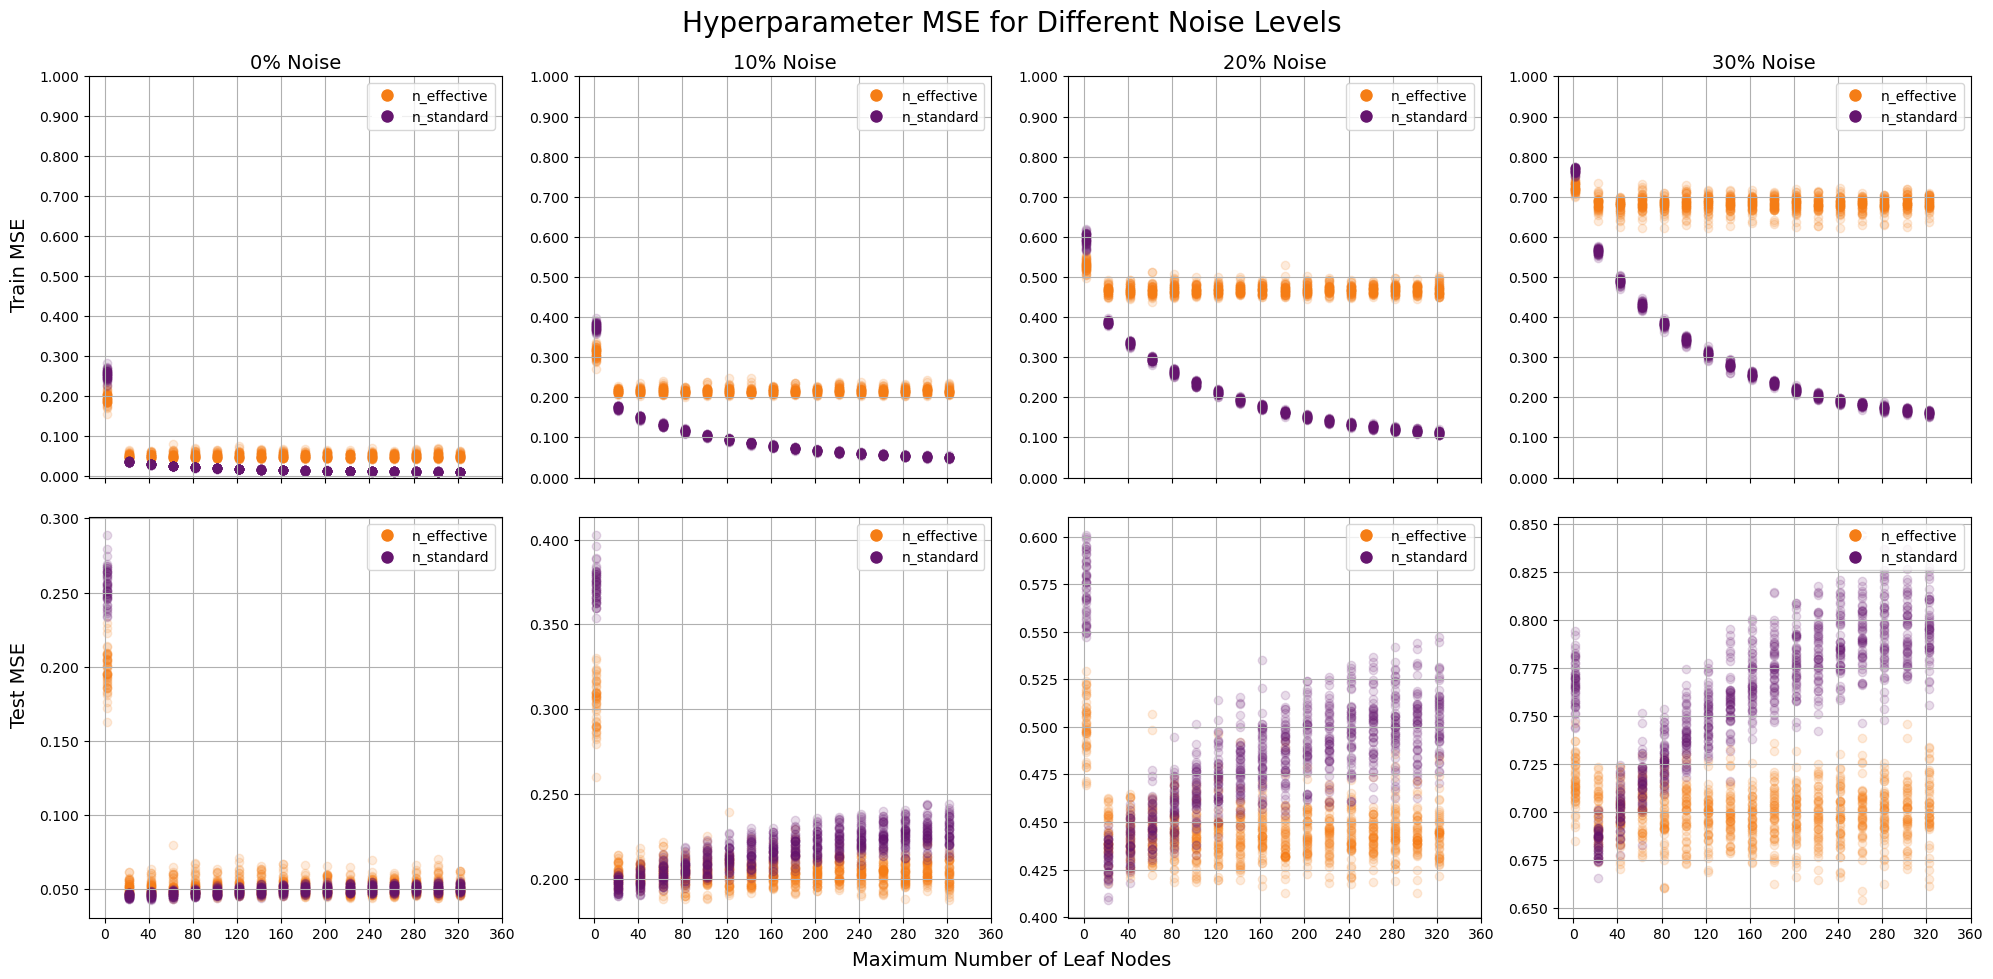

In [13]:
# Initialize the plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(top=0.88)

# Create legend entries
legend_elements = [Line2D([0], [0], marker='o', color='w', label='n_effective', markerfacecolor=start_color, markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='n_standard', markerfacecolor=end_color, markersize=10)]

    
# Plot data
for idx, noise in enumerate(noise_levels):
    
    # Creating empty lists for trend plots
    trend_train_effective = np.zeros(len(data_train_effective['0'][0][0])) # Length of X-Axis for storing corresponding Y-Axis values
    trend_train_standard = np.zeros(len(data_train_effective['0'][0][0])) # Length of X-Axis for storing corresponding Y-Axis values
    
    # Plotting Hyperparameter Plots
    for idx2, data in enumerate(data_train_effective[noise]):
        axs[0, idx].scatter(data[0], list(data[1]), alpha=0.15, color=start_color)
        trend_train_effective += np.array(list(data[1]))
    for idx3, data in enumerate(data_train_standard[noise]):
        axs[0, idx].scatter(data[0], list(data[1]), alpha=0.15, color=end_color)
        trend_train_standard += np.array(list(data[1]))
    
    # Calculating means
    trend_train_effective /= idx2 + 1
    trend_train_standard /= idx3 + 1
    
    # Setting Plot Properties
    axs[0, idx].set_title(f'{noise}% Noise', fontsize=14)
    axs[0, idx].set_xticks(np.arange(0, max(x) + d_x, d_x))
    axs[0, idx].set_xticklabels([])
    axs[0, idx].set_yticks(np.arange(0, 1 + 0.1, 0.1))
    axs[0, idx].grid(True)
    axs[0, idx].legend(handles=legend_elements, loc='upper right', fontsize=10)
    axs[0, idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    
    # Creating empty lists for trend plots
    trend_test_effective = np.zeros(len(data_test_effective['0'][0][0])) # Length of X-Axis for storing corresponding Y-Axis values
    trend_test_standard = np.zeros(len(data_test_effective['0'][0][0])) # Length of X-Axis for storing corresponding Y-Axis values
    
    # Plotting Hyperparameter Plots
    for idx4, data in enumerate(data_test_effective[noise]):
        axs[1, idx].scatter(data[0], list(data[1]), alpha=0.15, color=start_color)
        trend_test_effective += np.array(list(data[1]))
    for idx5, data in enumerate(data_test_standard[noise]):
        axs[1, idx].scatter(data[0], list(data[1]), alpha=0.15, color=end_color)
        trend_test_standard += np.array(list(data[1]))
    
    # Calculating means
    trend_test_effective /= idx4 + 1
    trend_test_standard /= idx5 + 1
        
    axs[1, idx].set_xticks(np.arange(0, max(x) + d_x, d_x))
    #axs[1, idx].set_yticks(np.arange(0, 1 + 0.1, 0.1))
    axs[1, idx].grid(True)
    axs[1, idx].legend(handles=legend_elements, loc='upper right', fontsize=10)
    axs[1, idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Add common labels
fig.text(0.5, 0.01, 'Maximum Number of Leaf Nodes', ha='center', va='center', fontsize=14)

# Get position and size of each axis
position = [ax.get_position() for ax in axs.ravel()]
plot_dist = position[1].x0 - position[0].x0

fig.text(position[0].x0 - plot_dist / 2 - 0.020, (position[0].y0 + position[0].y1) / 2, 'Train MSE', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(position[4].x0 - plot_dist / 2 - 0.020, (position[4].y0 + position[4].y1) / 2, 'Test MSE', ha='center', va='center', rotation='vertical', fontsize=14)


plt.suptitle('Hyperparameter MSE for Different Noise Levels', fontsize=20, y=0.96)
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=1.0)
plt.savefig('paper_images/hyp_vs_mse.png', dpi=600)
plt.show()

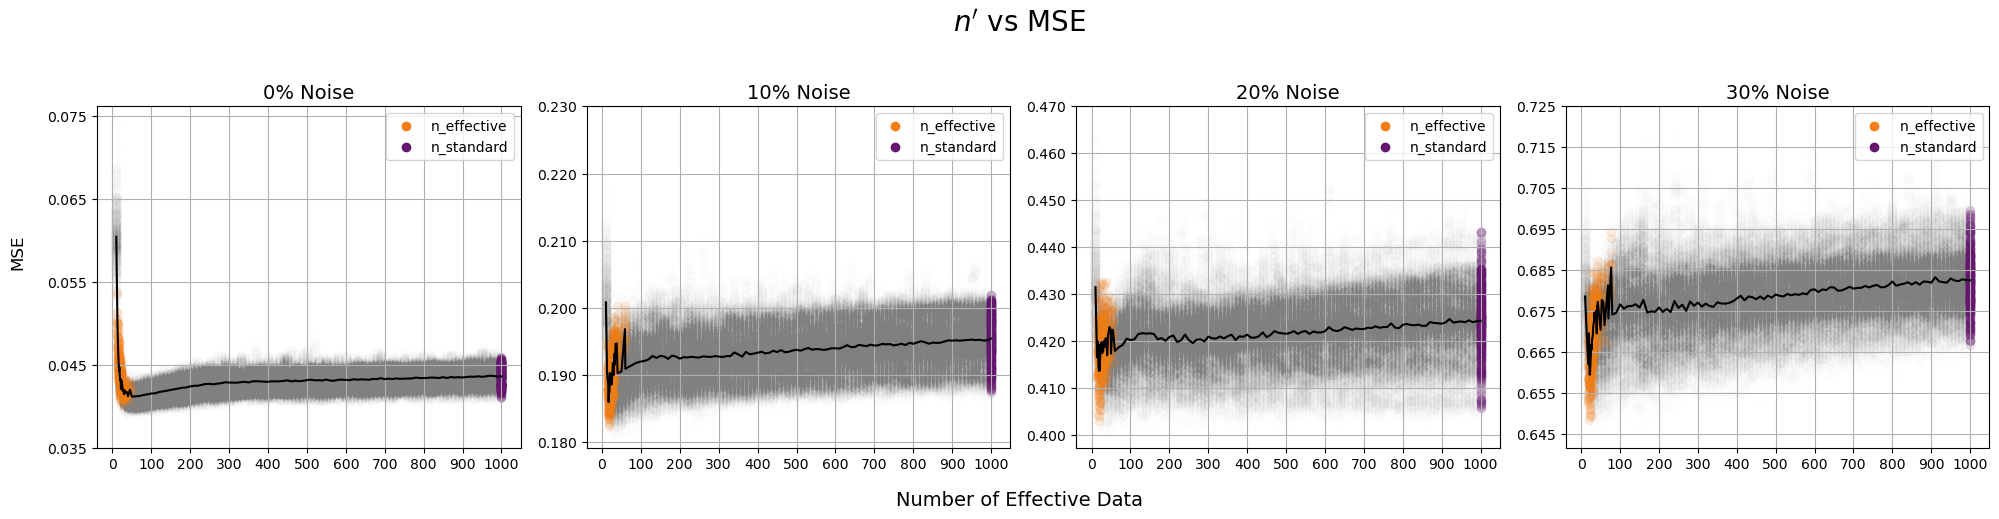

In [2]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(top=0.88, hspace=0.4)

# Plotting MSE data
for idx, noise in enumerate(noise_levels):
    # Separate data into two categories: n_effective and not n_effective
    n_effective_data = [data for data in mse_plot_data[noise] if data[3]]
    n_standard_data = [data for data in mse_plot_data[noise] if data[4]]
    n_other_data = [data for data in mse_plot_data[noise] if((not data[3]) and (not data[4]))]
    n_all = [data for data in mse_plot_data[noise]] # For plotting the average
    
    # Sort the list of tuples based on the first element (x)
    n_all.sort(key=lambda t: t[1])
    # Group the tuples by the first element (x)
    groups = groupby(n_all, key=lambda t: t[1])

    # Calculate the mean of the second element (y) for each group
    means = {key: mean(t[2] for t in group) for key, group in groups}
    
    # Plot data with different colors based on n_effective
    axs[idx].scatter([x for c, x, y, z, q in n_other_data], [y for c, x, y, z, q in n_other_data], color='grey', alpha=0.008)
    axs[idx].scatter([x for c, x, y, z, q in n_effective_data], [y for c, x, y, z, q in n_effective_data], color=start_color, label='n_effective', alpha=0.10)
    axs[idx].scatter([x for c, x, y, z, q in n_standard_data], [y for c, x, y, z, q in n_standard_data], color=end_color, label='n_standard', alpha=0.10)
    axs[idx].plot(list(means.keys()), means.values(), color='black')


    leg = axs[idx].legend(loc='upper right')   
    for lh in leg.legend_handles: 
        lh.set_alpha(1)

    axs[idx].set_title(f'{noise}% Noise', fontsize=14)
    axs[idx].set_xticks(np.arange(0, n_standard + d_n, d_n))
    
    # Calculate y_min and y_max
    y_min = min([y for c, x, y, p, q in n_all])
    y_max = max([y for c, x, y, p, q in n_all])

    # Round down y_min to nearest number divisible by 0.005
    y_min = math.floor(y_min / 0.005) * 0.005

    # Round up y_max to nearest number divisible by 0.005
    y_max = math.ceil(y_max / 0.005) * 0.005

    # Choose a gridsize
    gridsize = 0.01

    # Generate the y-tick values
    y_ticks = np.arange(y_min, y_max + gridsize, gridsize)
    
    # Set the y-ticks
    axs[idx].set_yticks(y_ticks)
    
    # Format y-axis digits
    axs[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    
    # Turn on grids
    axs[idx].grid(True)
    

# Get position and size of each axis
position = [ax.get_position() for ax in axs.ravel()]
plot_dist = position[1].x0 - position[0].x0

# Add common labels
fig.text(0.5, 0.0, 'Number of Effective Data', ha='center', va='center', fontsize=14)

fig.text(position[0].x0 - plot_dist / 2 - 0.025, (position[0].y0 + position[0].y1) / 2, 'MSE', ha='center', va='center', rotation='vertical', fontsize=12)

plt.suptitle(r"$n'$ vs MSE", fontsize=20)
plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=1.0)
plt.savefig('paper_images/n_vs_mse.png', dpi=600, bbox_inches='tight')

#plt.savefig('demonstrations/alpha_tweaked_axis_fixed.png', bbox_inches='tight')
plt.show()

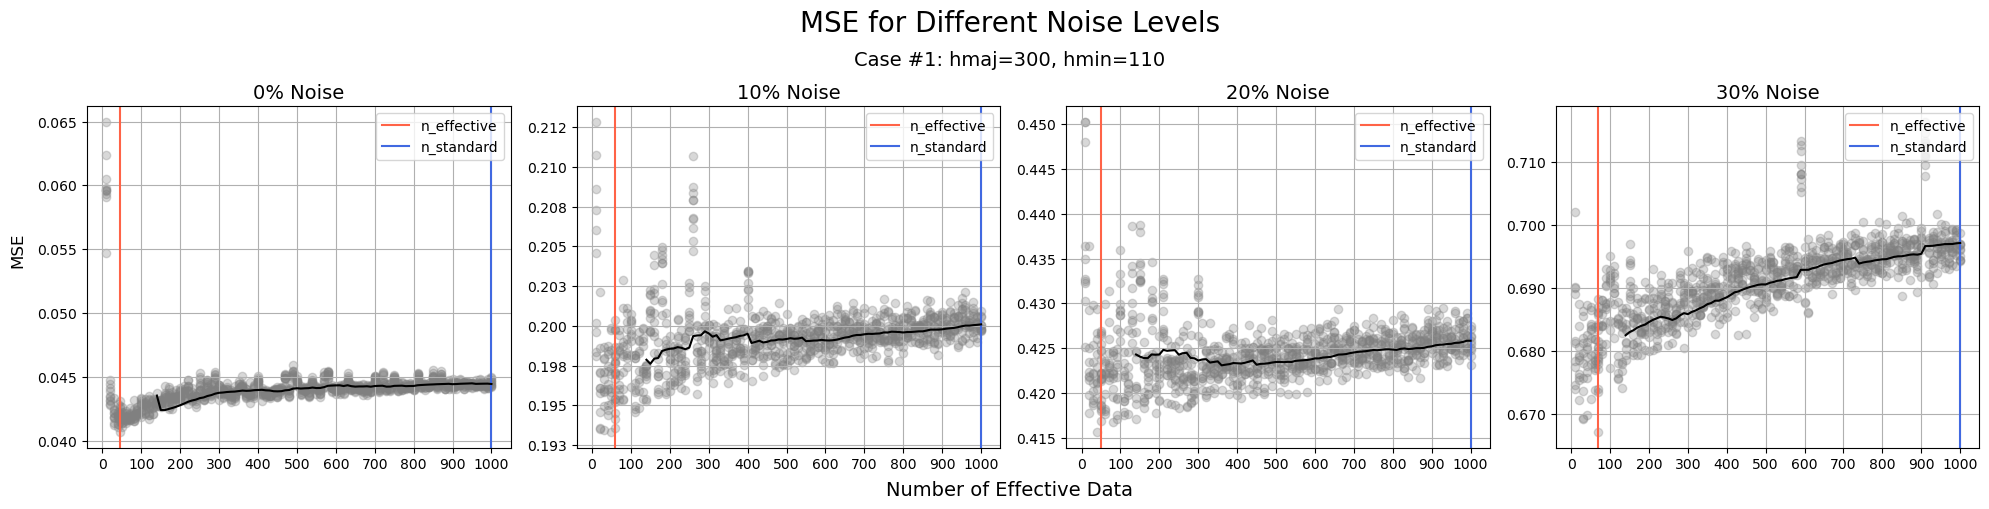

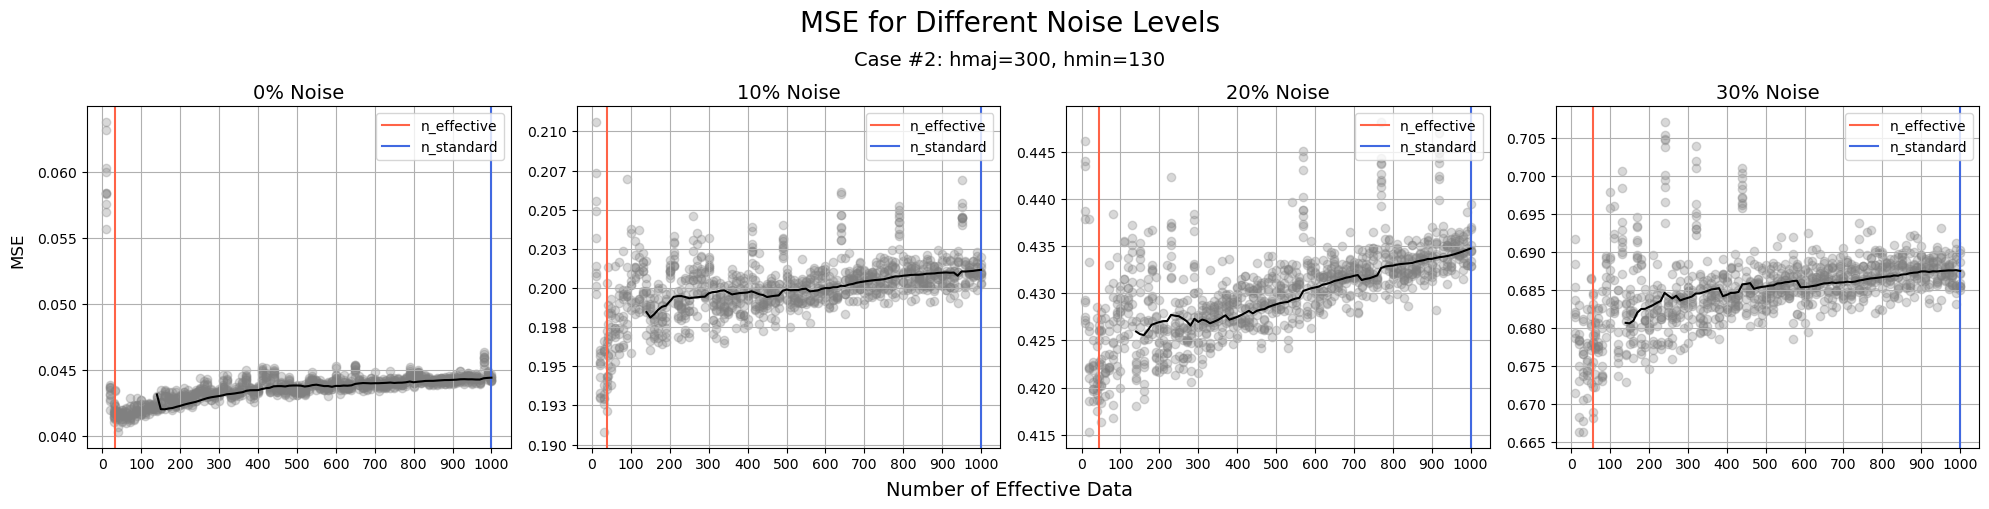

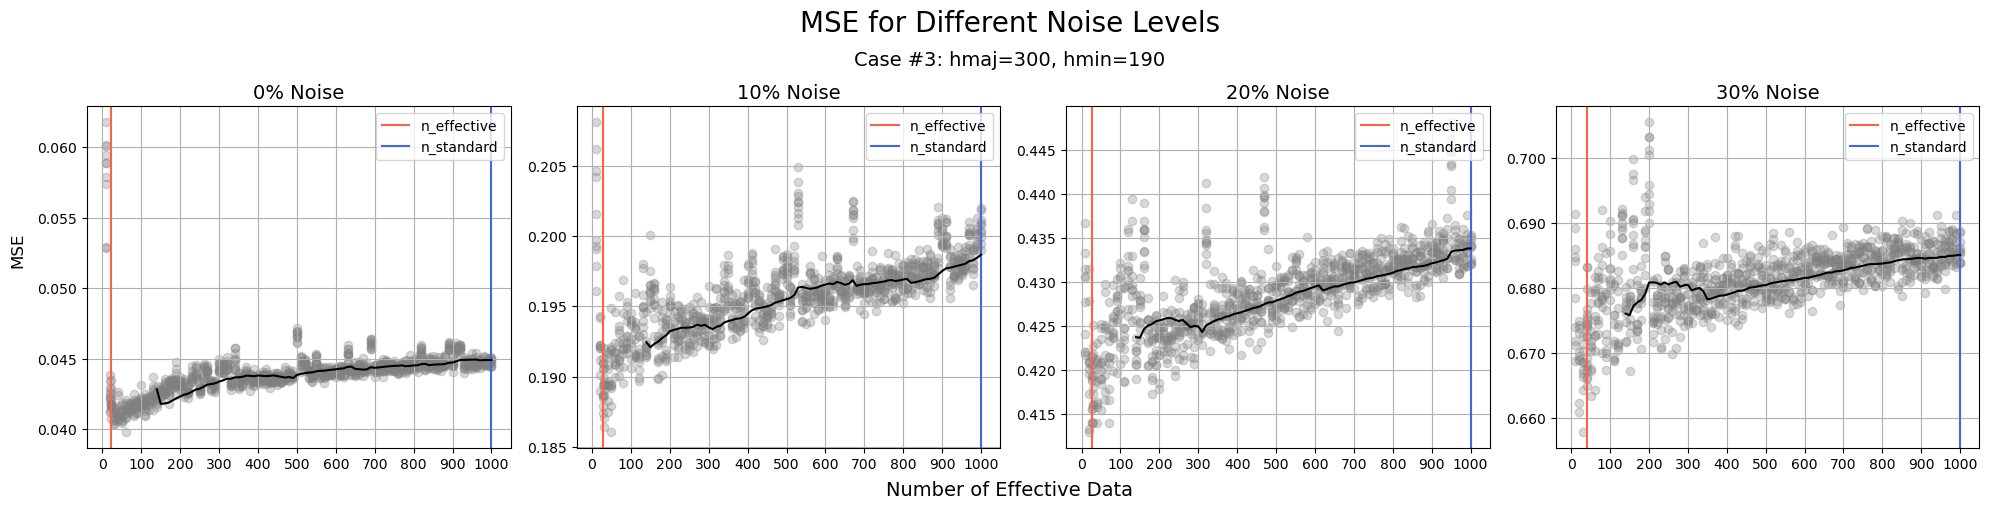

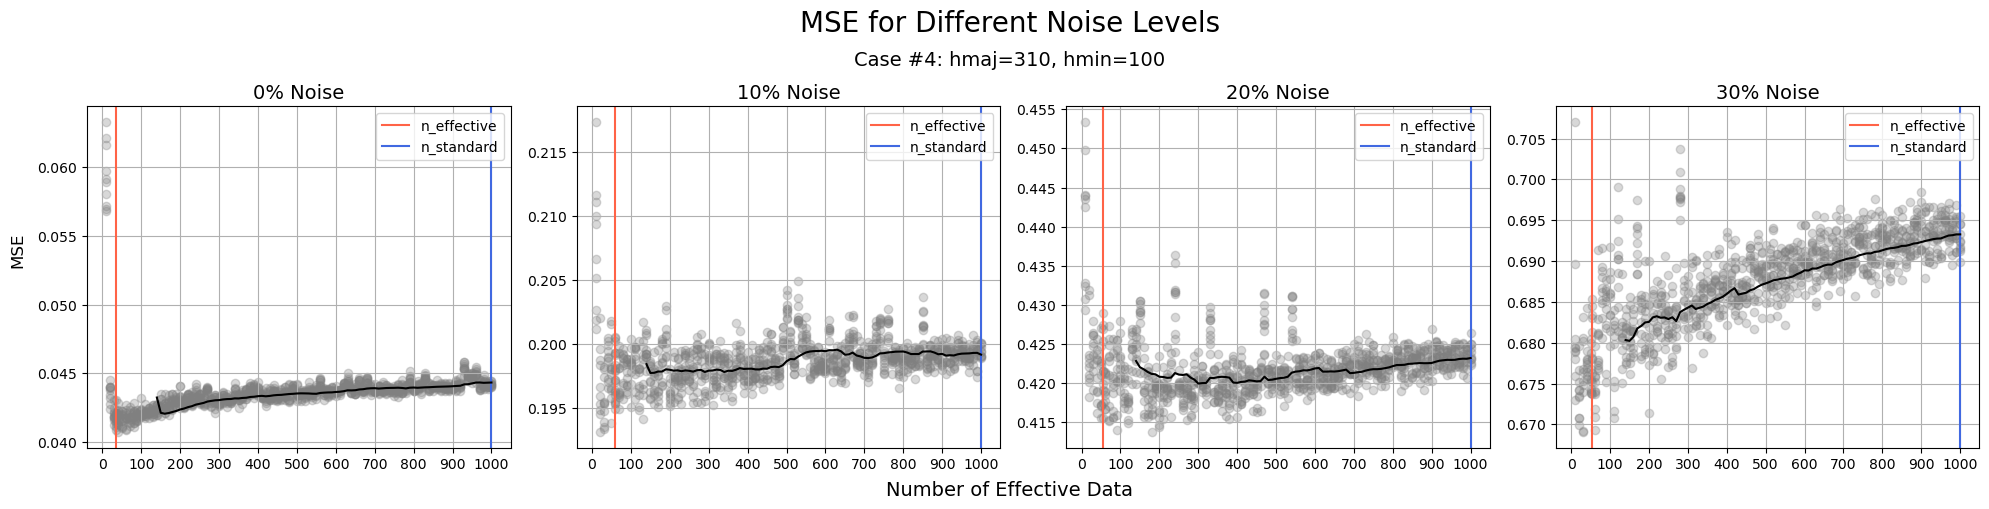

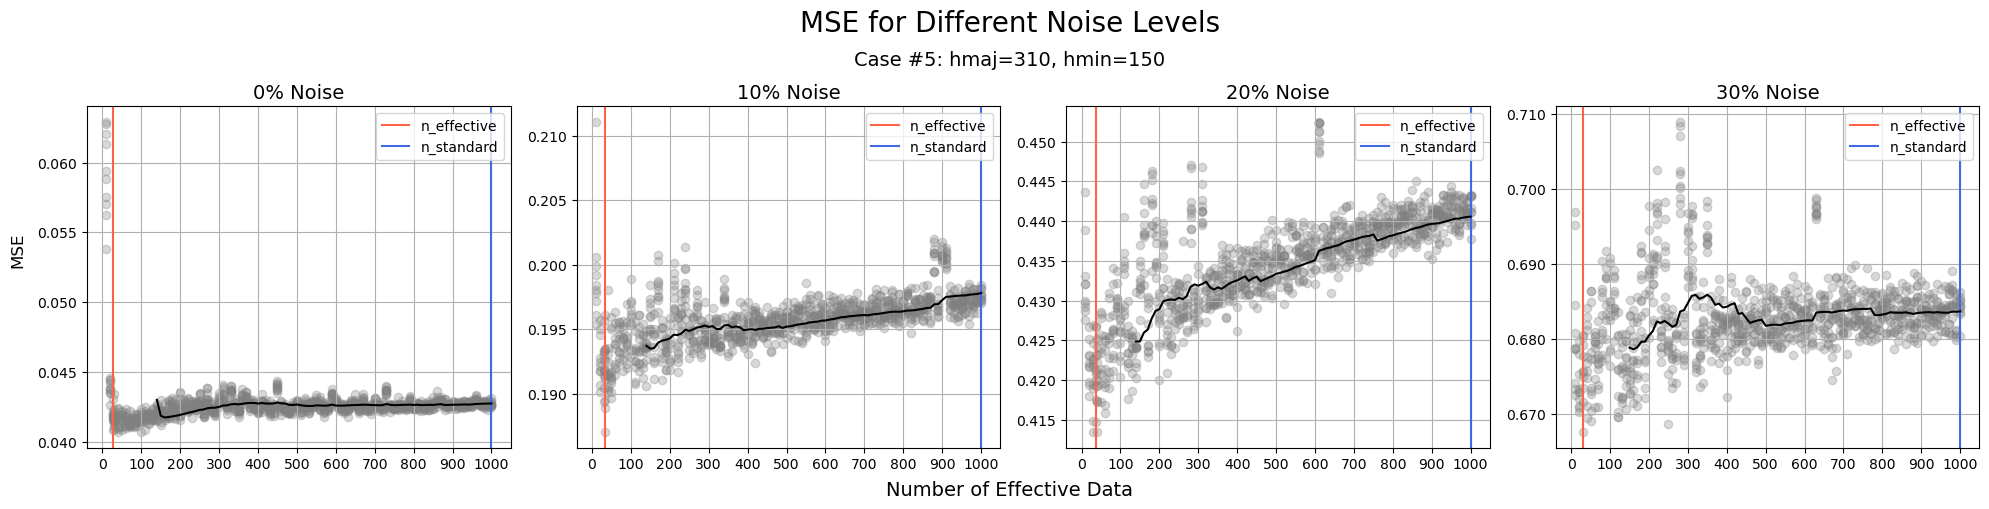

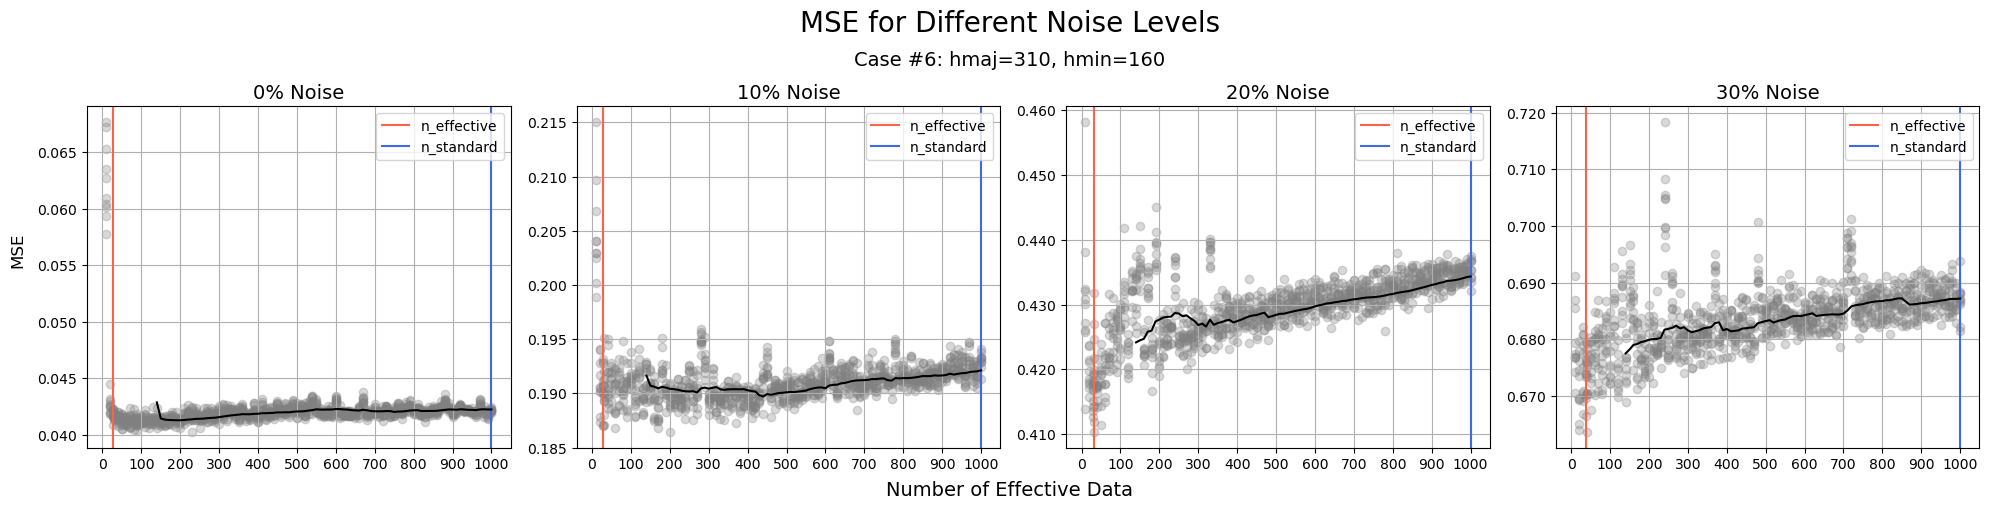

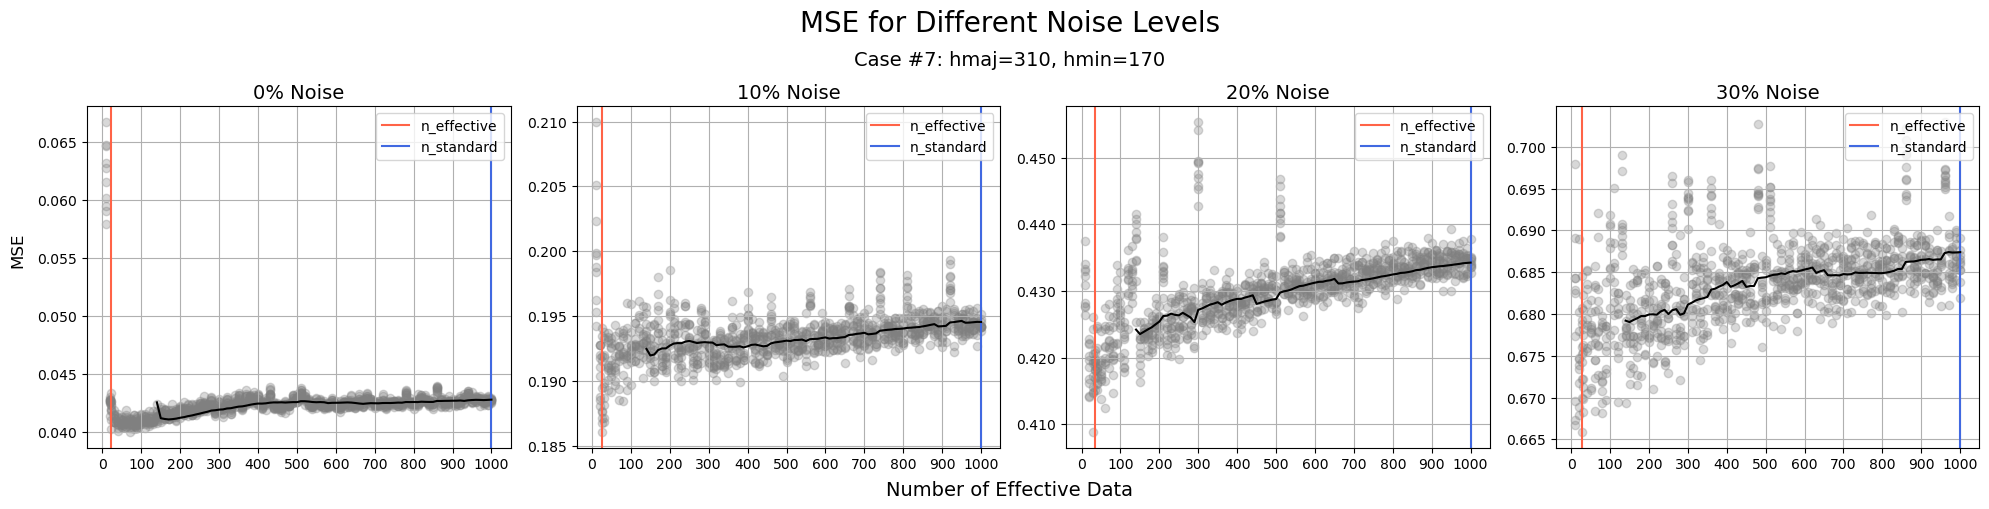

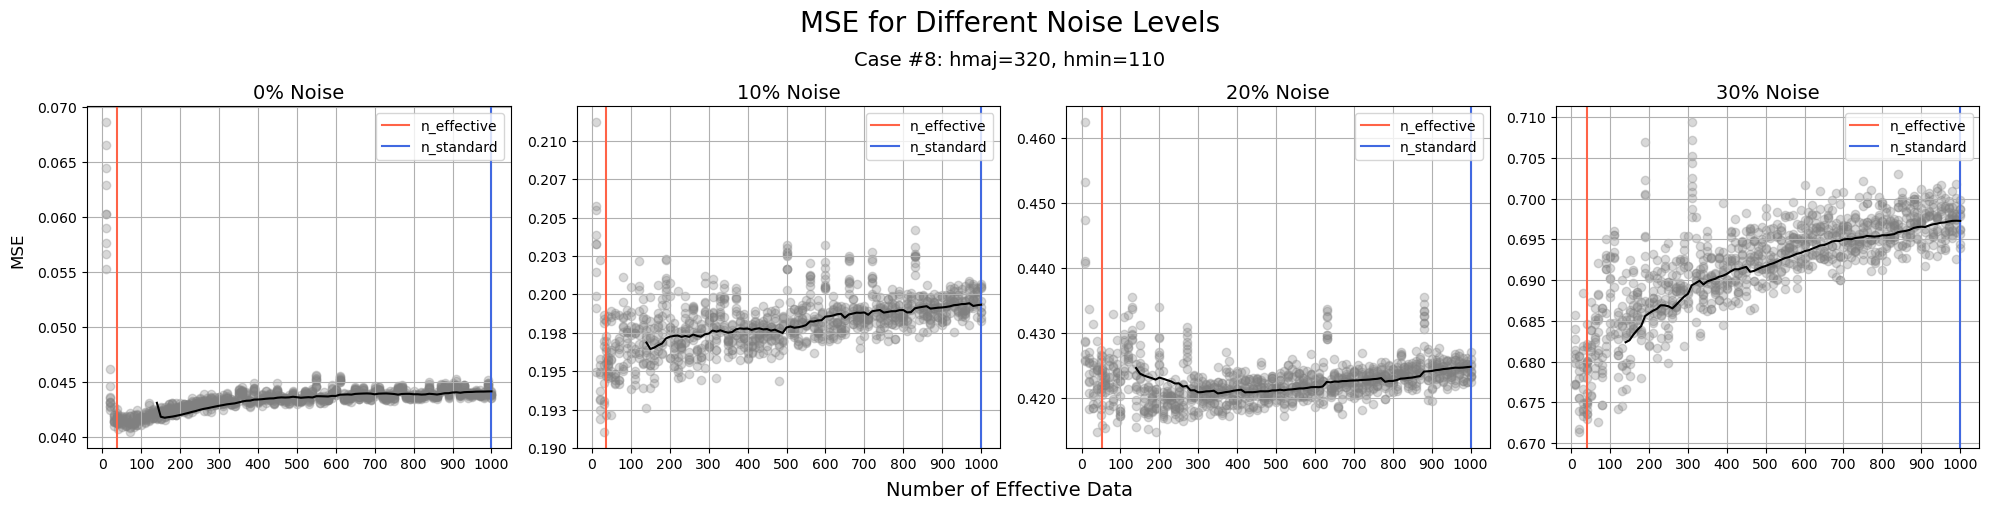

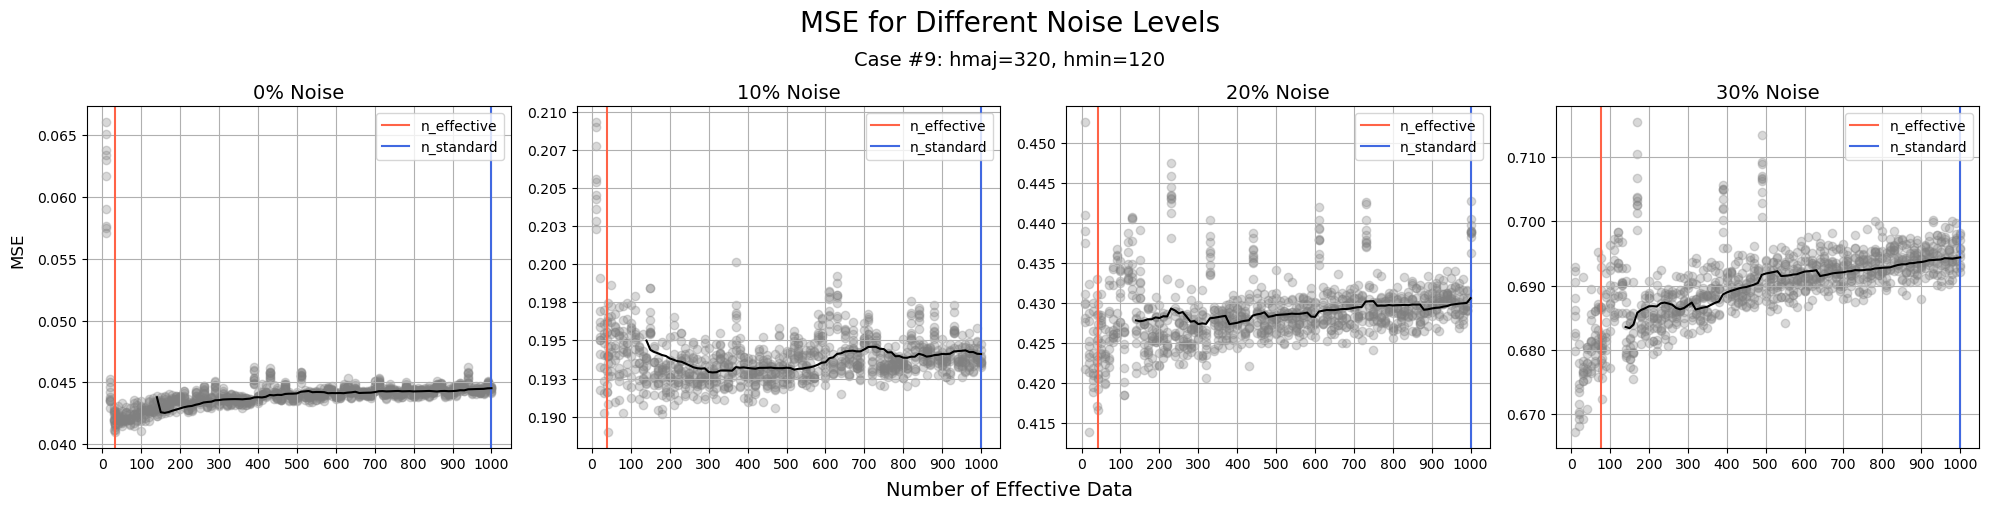

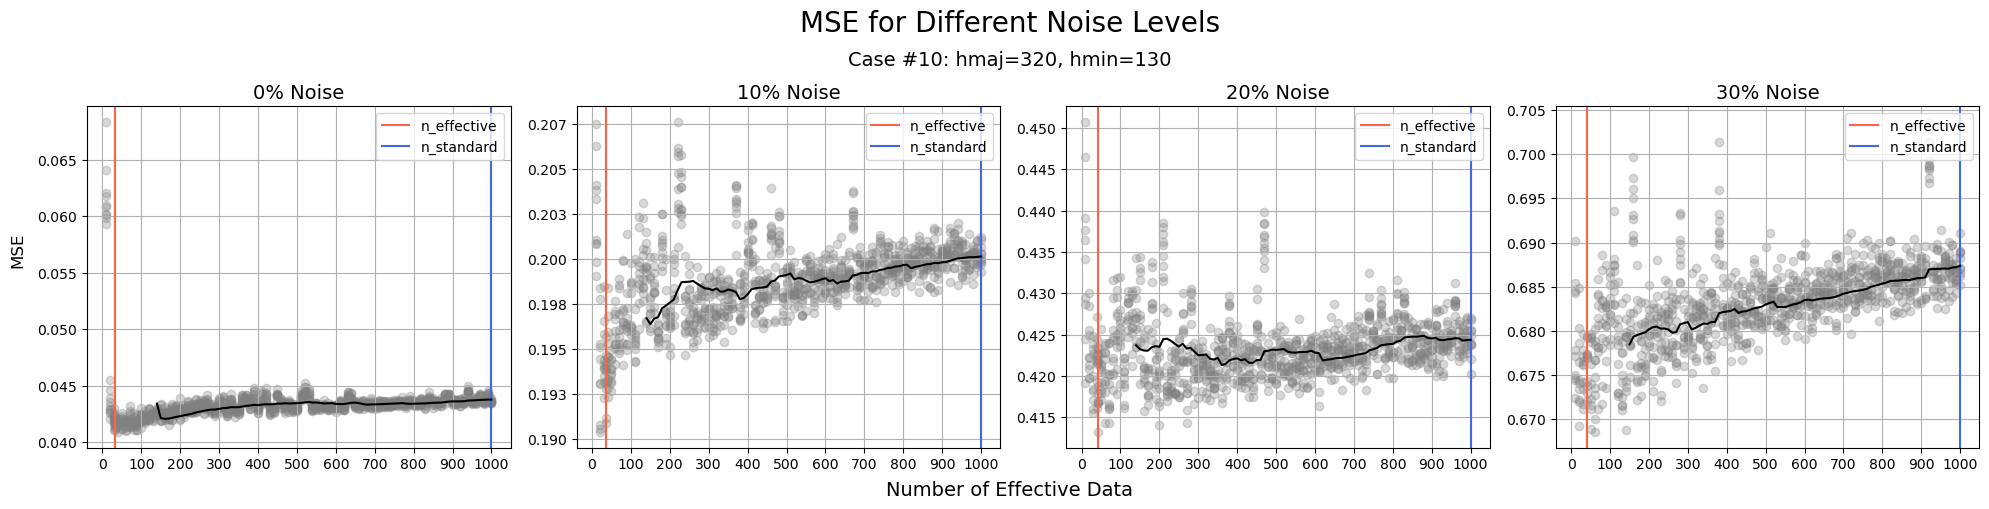

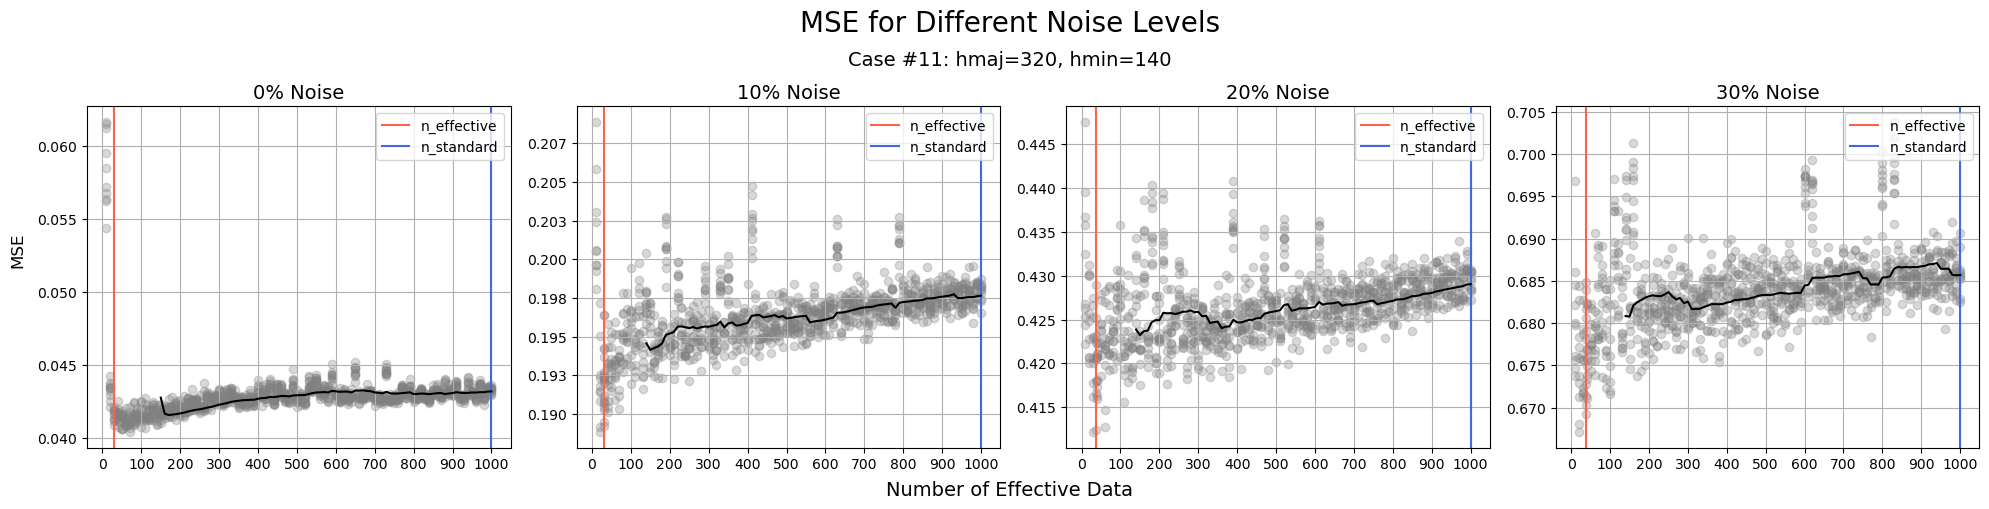

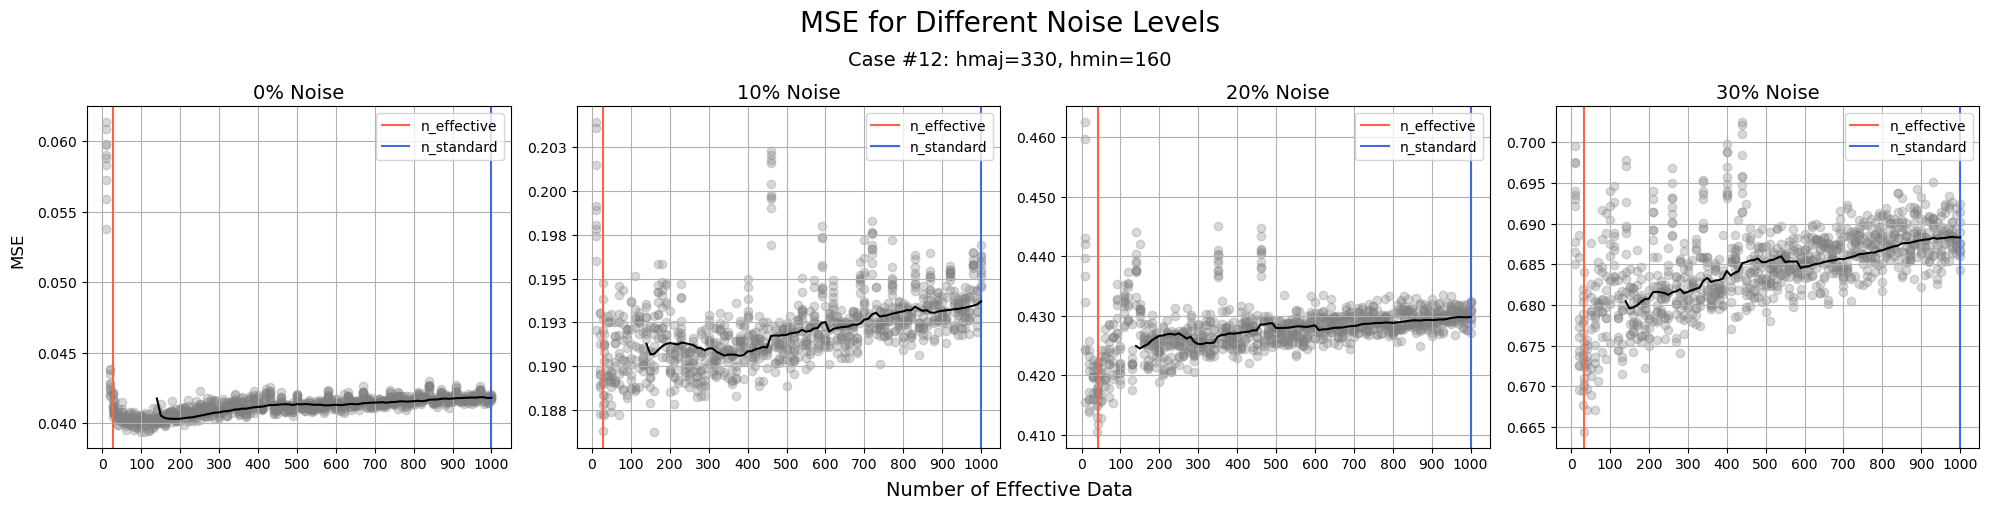

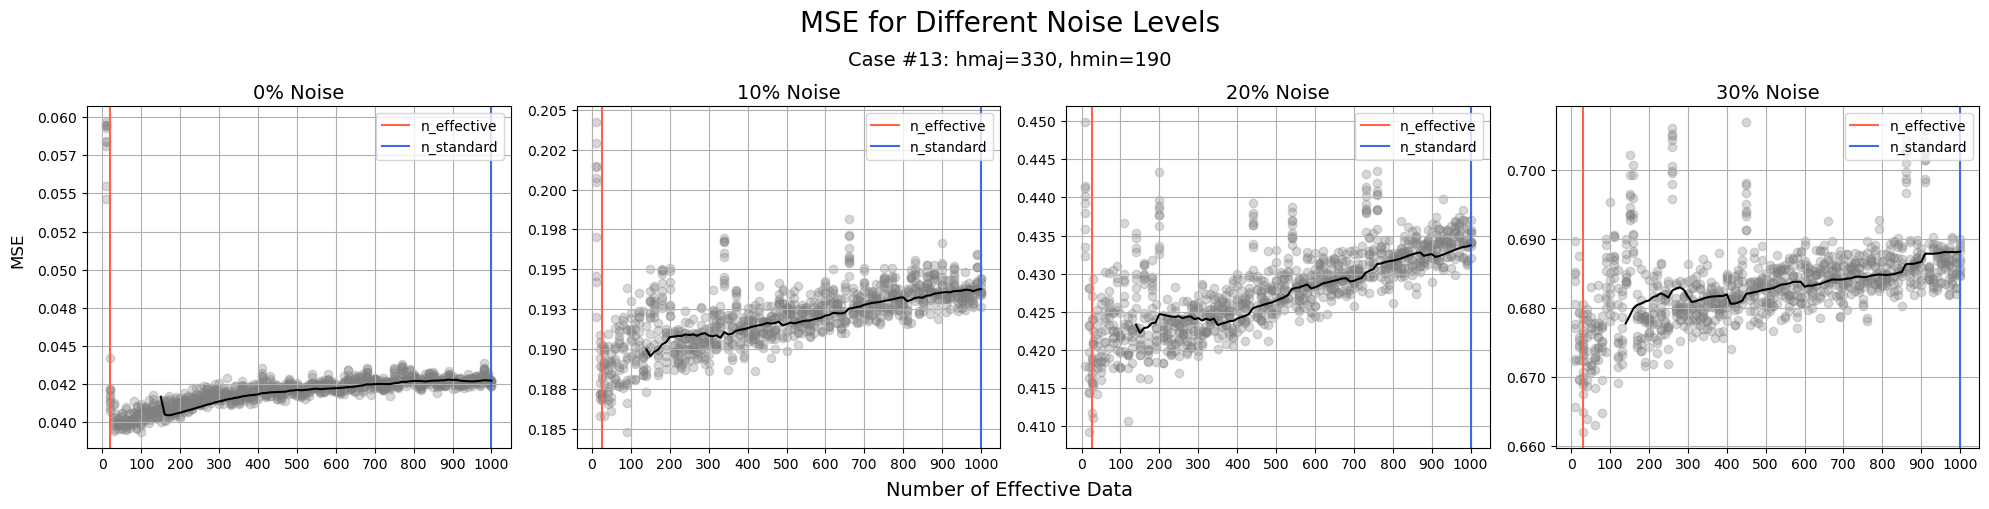

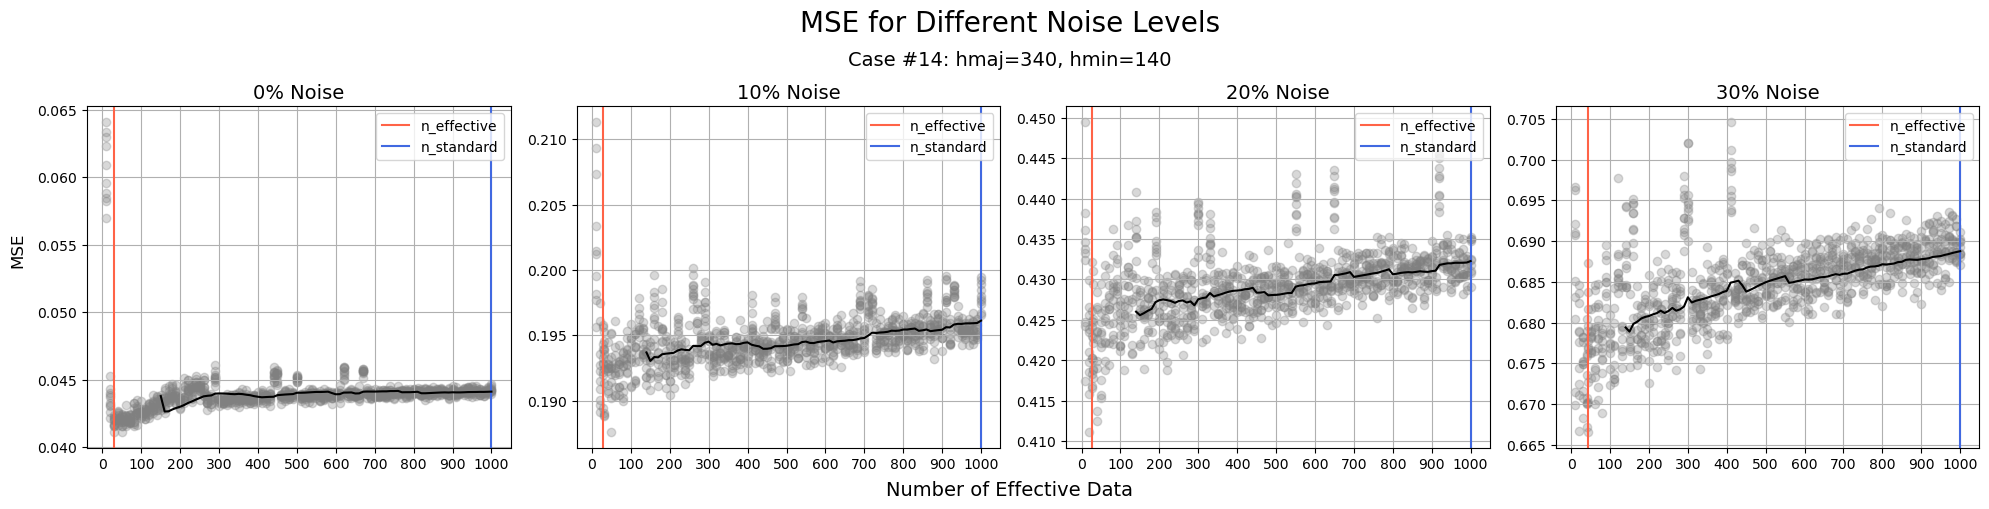

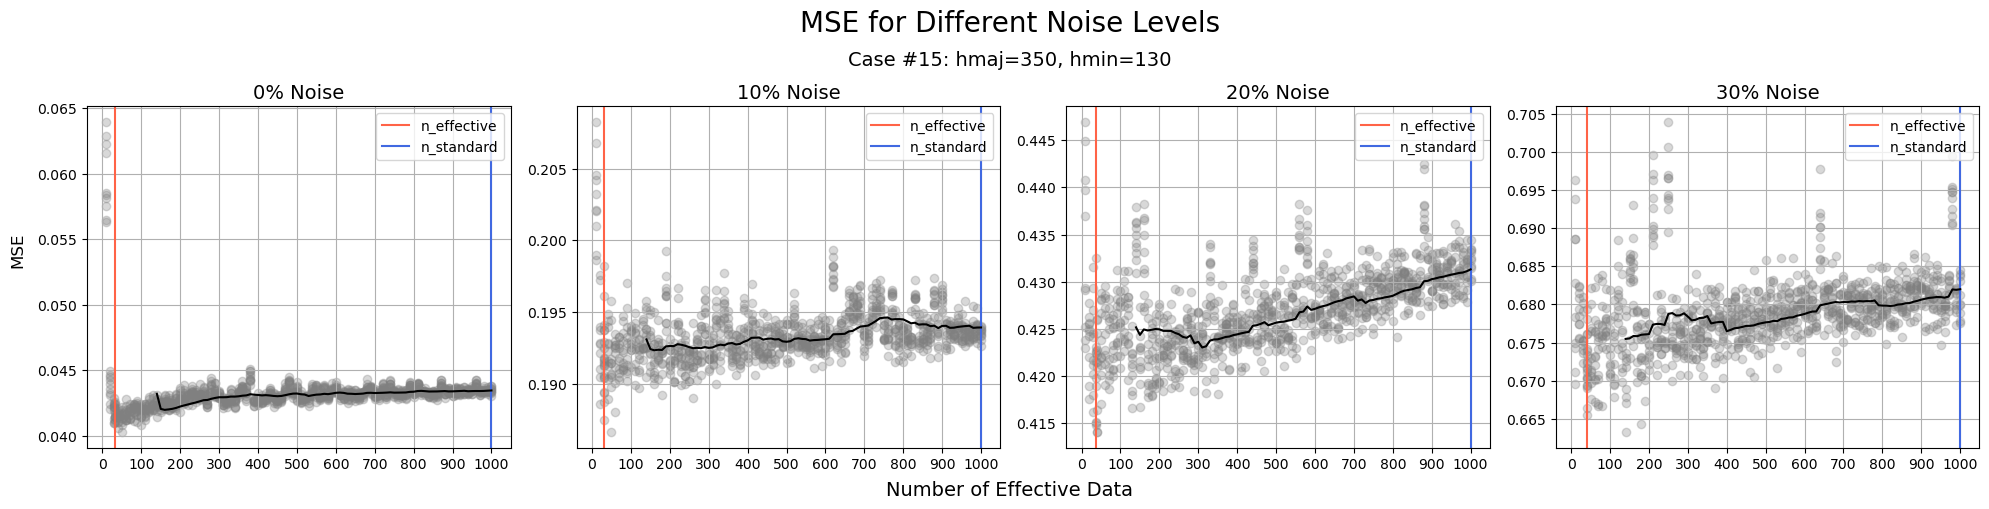

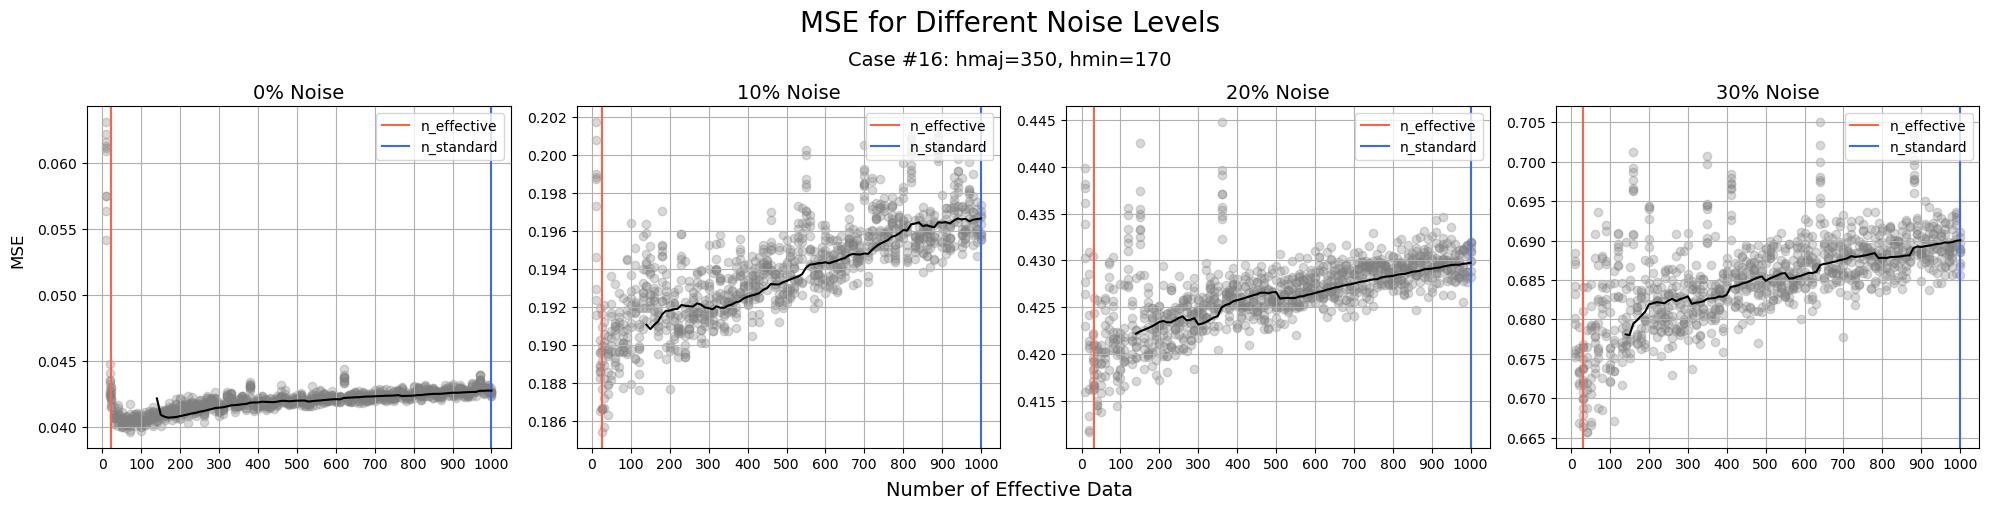

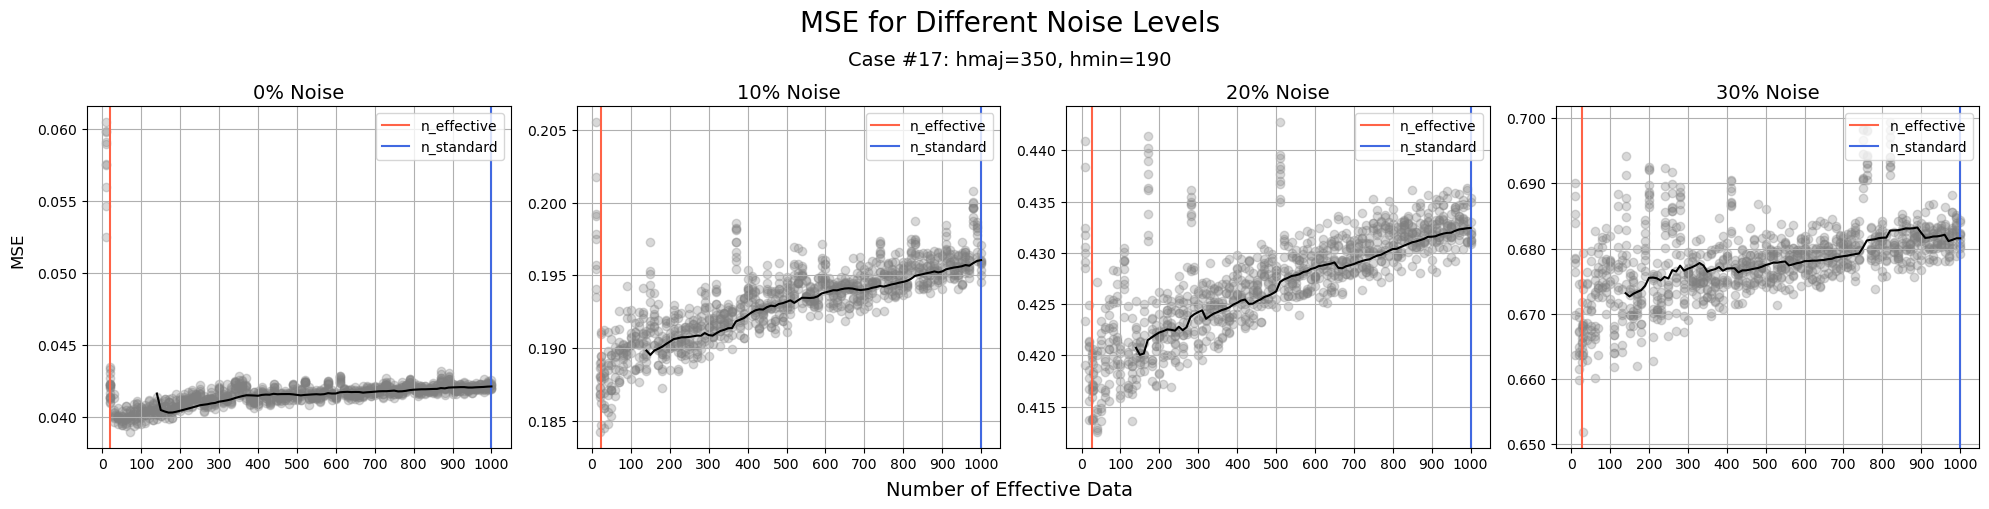

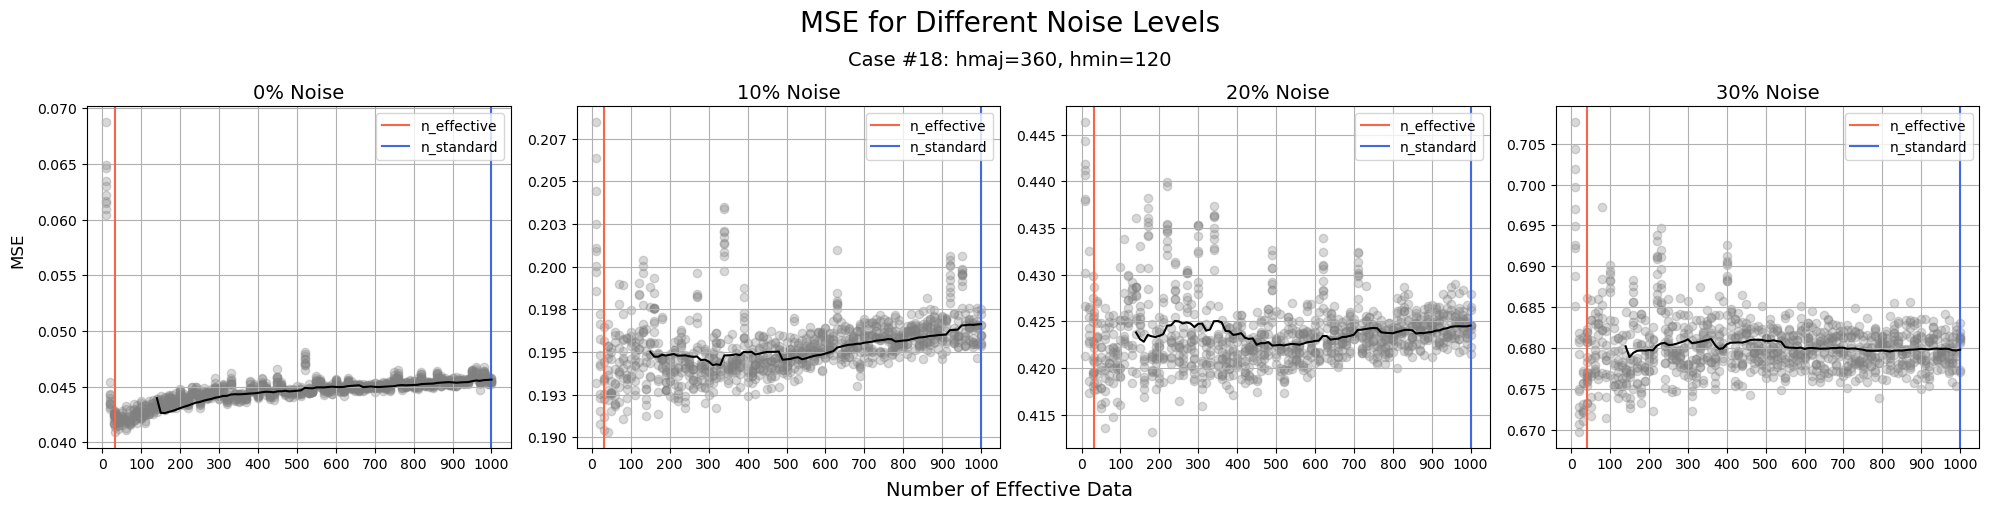

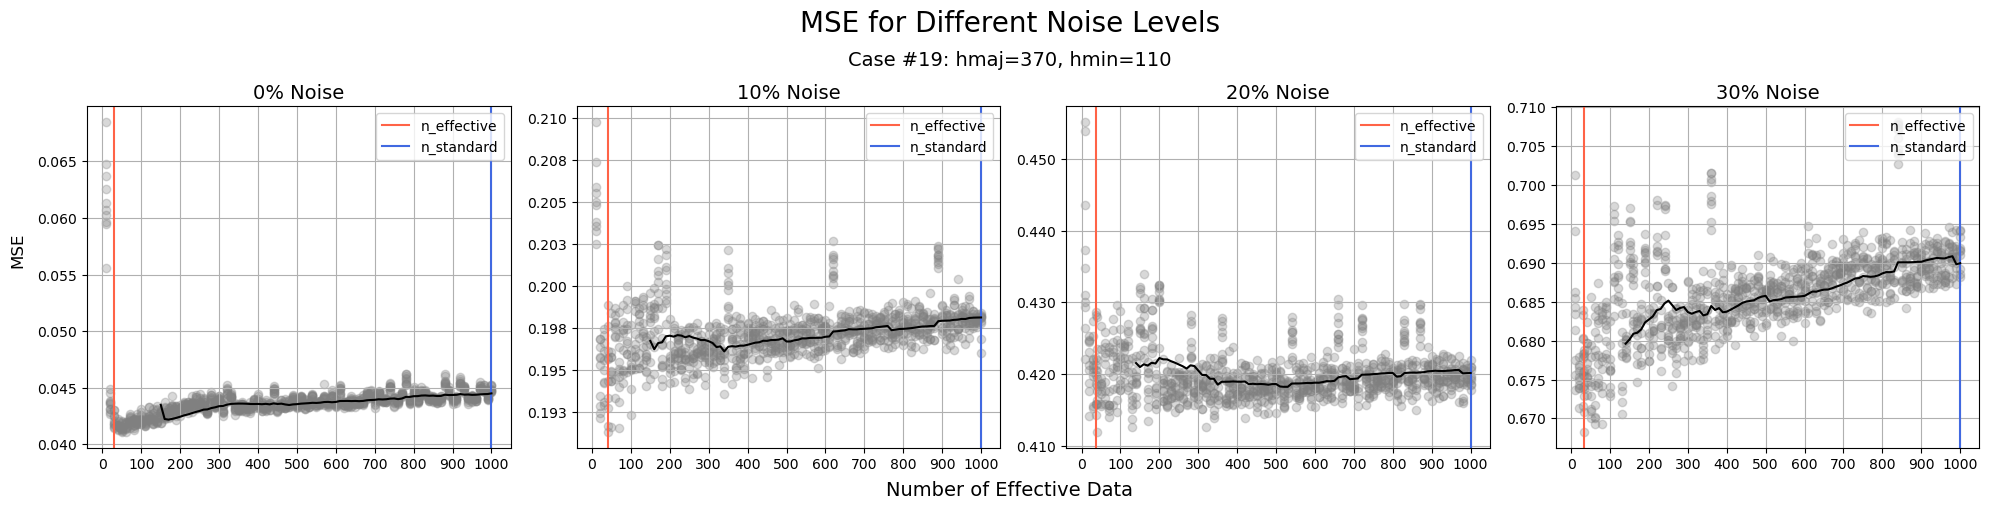

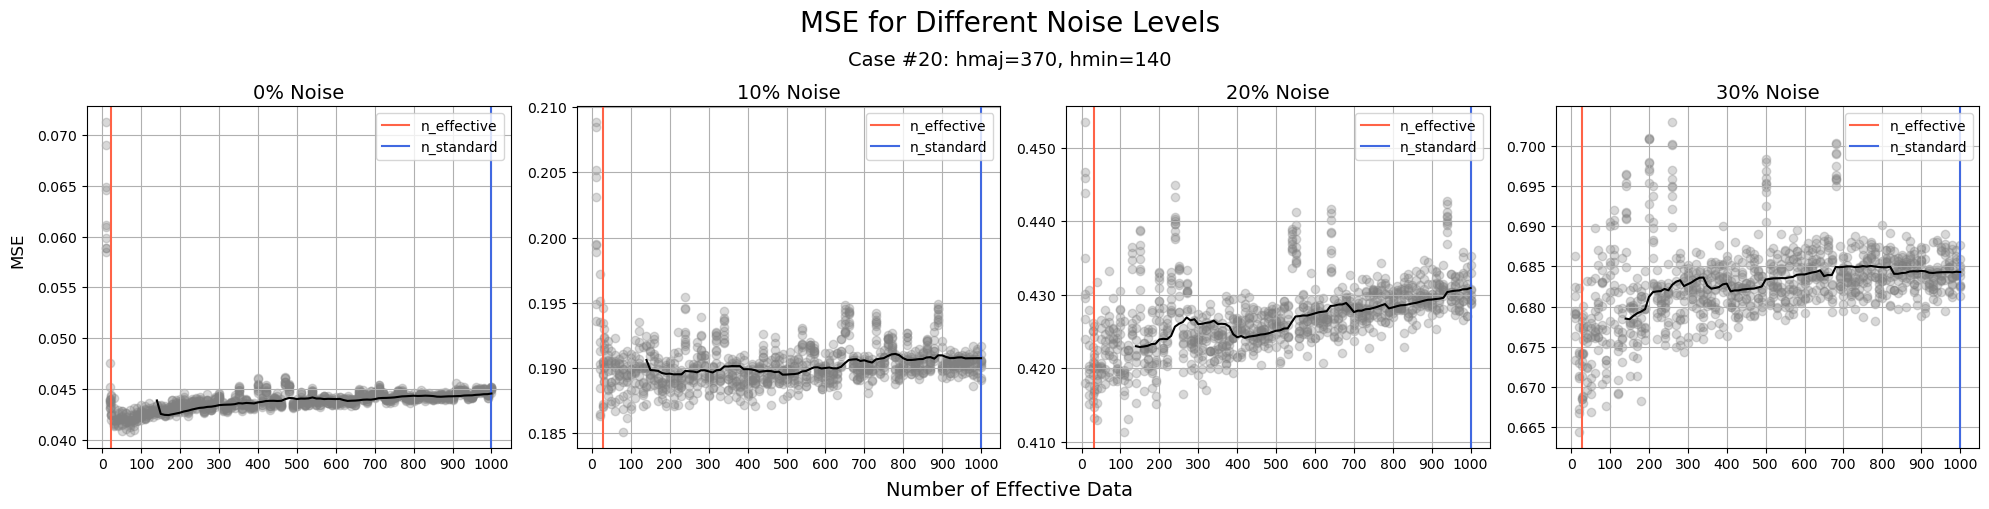

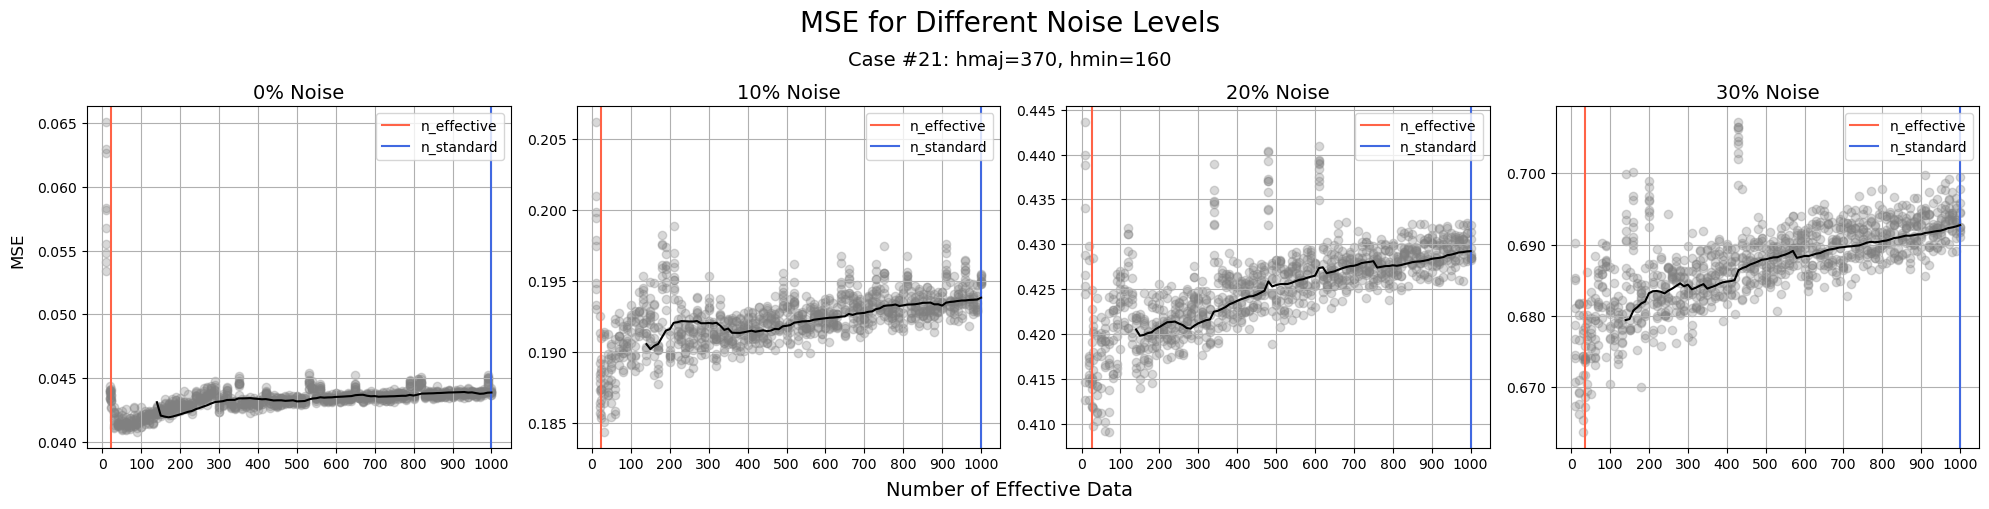

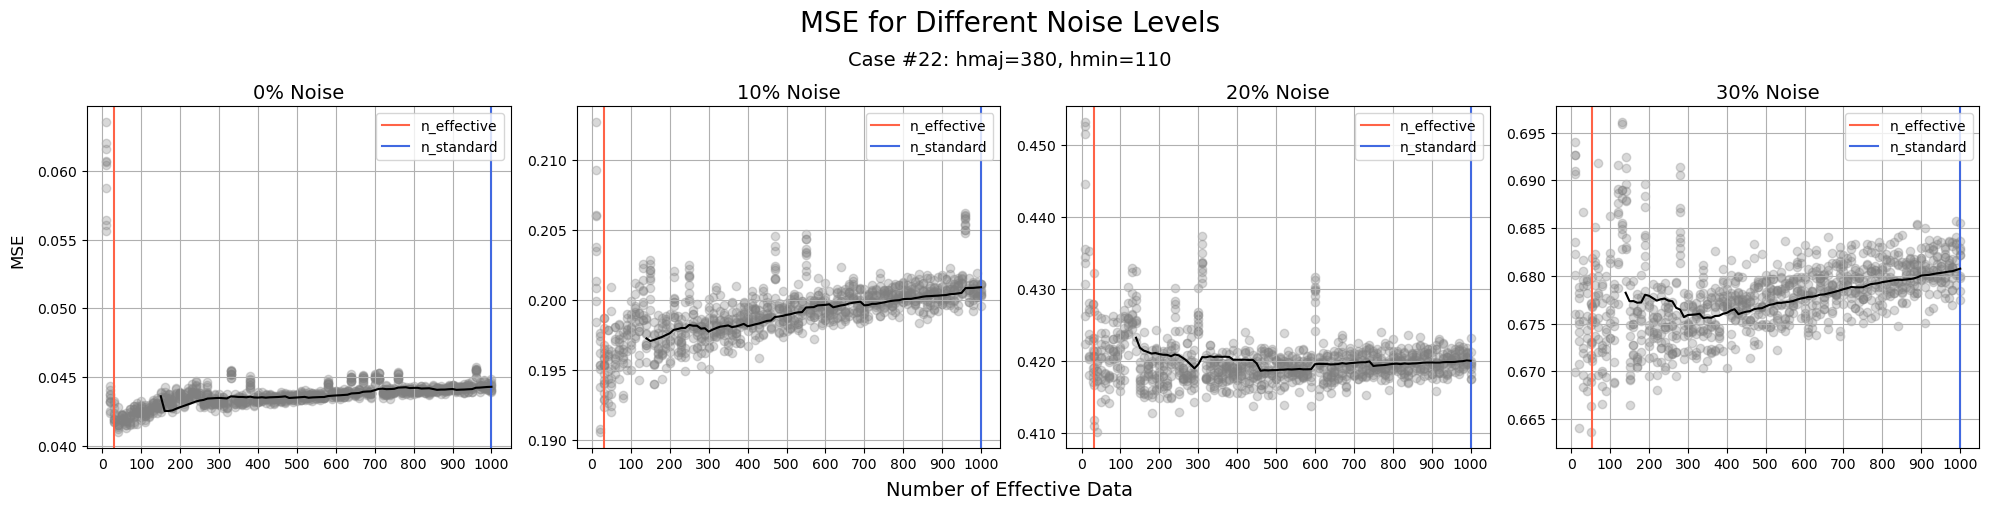

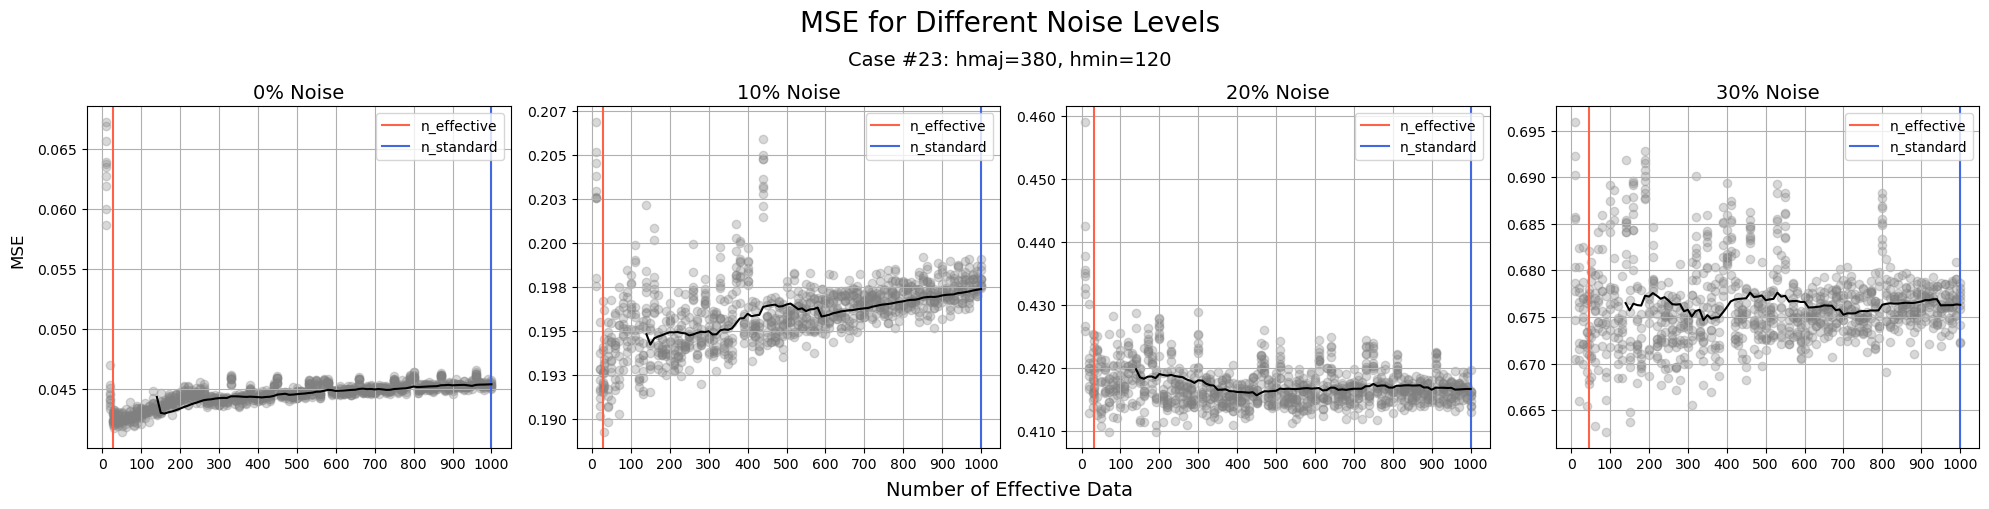

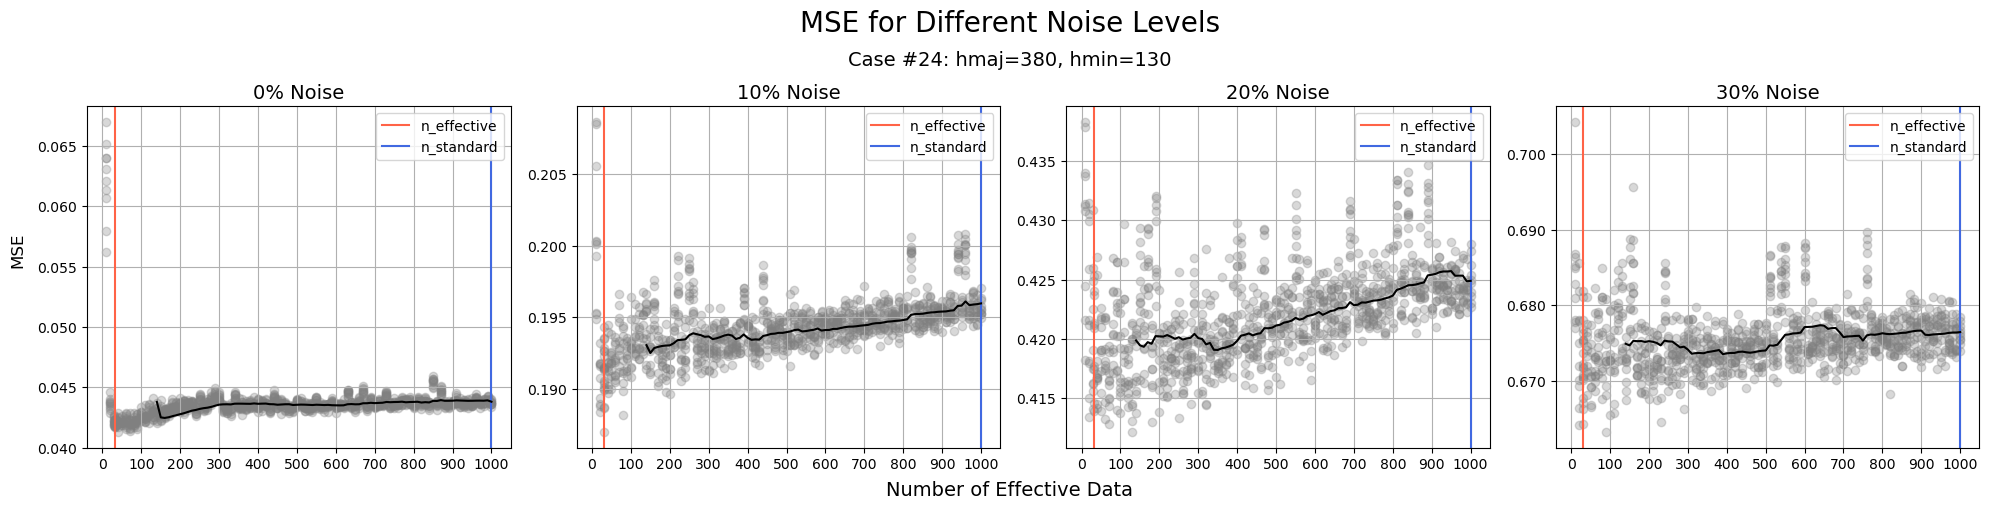

In [296]:
step = 1010 # Step for slicing mse_plot_data array for each data
cases_to_save = [2, 15, 23]
case_ct = max(cases_to_save)
for casenum in range(case_ct+1):
    interval = casenum * step * 4 # 4 levels of noise for each case (one interval of the list for that hmaj and hmin contains 4 noise level amount of index)
    # First plot: MSE vs Number of Effective Data
    fig1, axs1 = plt.subplots(1, 4, figsize=(20, 5))
    fig1.subplots_adjust(top=0.88)
    hmaj, hmin = filename_list[::4][casenum].split('_')[0], filename_list[::4][casenum].split('_')[1]
    fig1.text(0.5, 0.88, f'Case #{casenum+1}: hmaj={hmaj}, hmin={hmin}', ha='center', va='center', fontsize=14)
    
    # Plotting MSE data
    for idx, noise in enumerate(noise_levels):
        # Separate data into two categories: n_effective and not n_effective
        n_effective_data = [data for data in mse_plot_data[noise] if((data[0]==case_list[casenum*4]) and (data[3]))]
        n_standard_data = [data for data in mse_plot_data[noise] if((data[0]==case_list[casenum*4]) and (data[4]))]
        n_other_data = [data for data in mse_plot_data[noise] if((data[0]==case_list[casenum*4]) and (not data[3]) and (not data[4]))]
        n_all = [data for data in mse_plot_data[noise] if(data[0]==case_list[casenum*4])] # For plotting the average

        
        # Sort the list of tuples based on the first element (x)
        n_all.sort(key=lambda t: t[1])
        # Group the tuples by the first element (x)
        groups = groupby(n_all, key=lambda t: t[1])

        # Calculate the mean of the second element (y) for each group
        means = {key: mean(t[2] for t in group) for key, group in groups}
        
        # Convert the means to a pandas DataFrame
        means_df = pd.DataFrame(list(means.items()), columns=['Number of Effective Data', 'MSE'])

        # Calculate the moving window average with a window size of 'n'
        n = 15  # Window size
        means_df['Moving Average'] = means_df['MSE'].rolling(window=n).mean()
        
        # Scatter plot all data with grey color
        axs1[idx].scatter([x for c, x, y, z, q in n_all], [y for c, x, y, z, q in n_all], color='grey', alpha=0.3)

        # For n_effective and n_standard, get their x values (number of effective/standard data) 
        # and plot vertical lines at these x values.
        x_n_effective = [x for c, x, y, z, q in n_effective_data][0]
        x_n_standard = [x for c, x, y, z, q in n_standard_data][0]
        
        axs1[idx].axvline(x=x_n_effective, color='tomato', label='n_effective')
        axs1[idx].axvline(x=x_n_standard, color='royalblue', label='n_standard')

        # Use them to make the legend
        axs1[idx].legend(custom_lines, ['n_effective', 'n_standard'], loc='upper right')
        
        # Plot the moving window average
        axs1[idx].plot(means_df['Number of Effective Data'], means_df['Moving Average'], color='black')

        leg = axs1[idx].legend(loc='upper right')   
        for lh in leg.legend_handles: 
            lh.set_alpha(1)

        axs1[idx].set_title(f'{noise}% Noise', fontsize=14)
        axs1[idx].set_xticks(np.arange(0, n_standard + d_n, d_n))
        axs1[idx].grid(True)
        axs1[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

    # Get position and size of each axis
    position_1 = [ax.get_position() for ax in axs1.ravel()]
    plot_dist_1 = position_1[1].x0 - position_1[0].x0
    fig1.text(position[0].x0 - plot_dist / 2 - 0.020, 0.5, 'MSE', ha='center', va='center', rotation='vertical', fontsize=12)
    fig1.text(0.5, 0.02, 'Number of Effective Data', ha='center', va='center', fontsize=14)
    

    fig1.suptitle('MSE for Different Noise Levels', fontsize=20)
    plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=1.0)
    if(casenum+1 in cases_to_save):
        #plt.savefig(f'mse_case_{casenum+1}.png', dpi=600)
        plt.savefig(f'demonstrations/mse_case_{casenum+1}_windowsize{n}.png', dpi=400)
        pass
    plt.show()

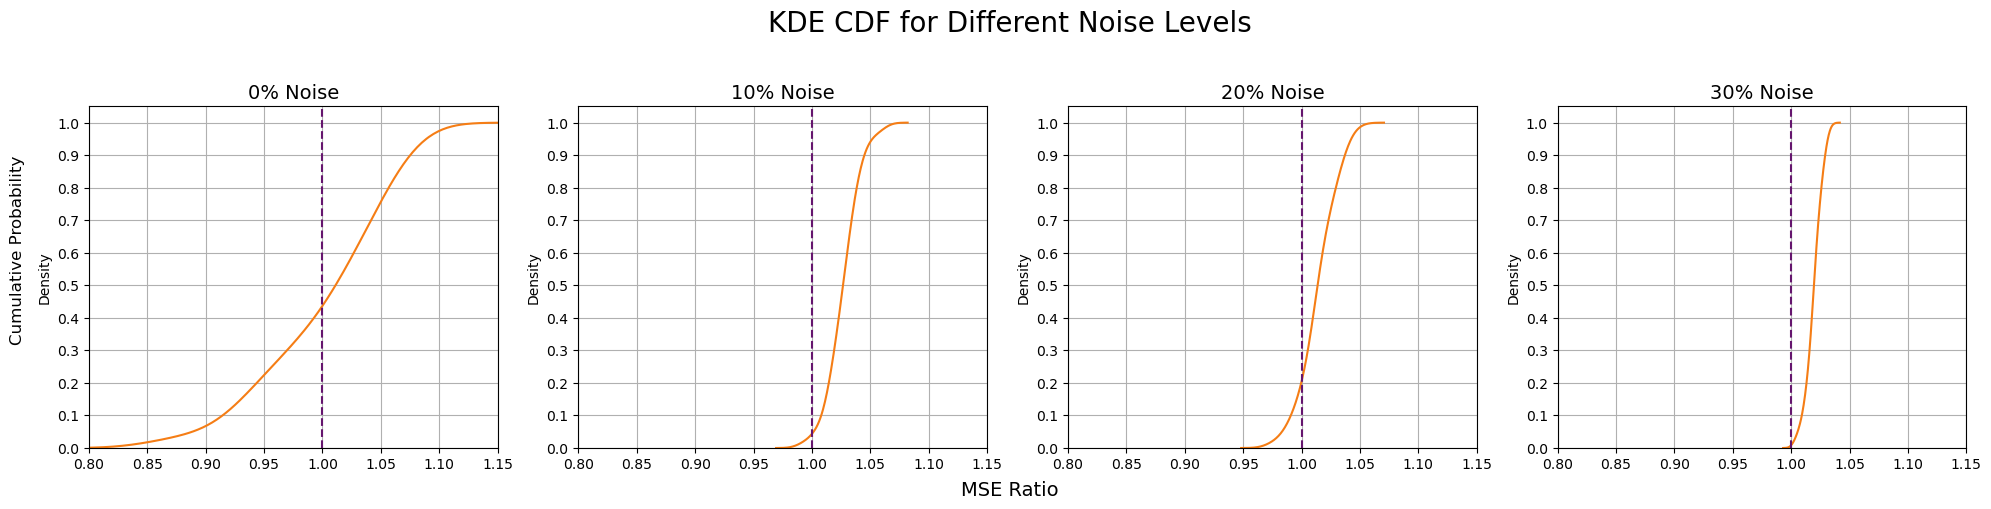

In [8]:
# Second plot: MSE Ratios Cumulative Probability Density Function
fig2, axs2 = plt.subplots(1, 4, figsize=(20, 5))
fig2.subplots_adjust(top=0.88)

for idx, noise in enumerate(noise_levels):
    axs2[idx].set_title(f'{noise}% Noise', fontsize=14)
    sns.kdeplot(mse_ratios_noise[noise], color=start_color, ax=axs2[idx], cumulative=True)
    axs2[idx].set_xlim([0.80,1.15])
    axs2[idx].axvline(x=1.0, color=end_color, linestyle='--')
    axs2[idx].grid(True)
    axs2[idx].set_yticks(np.arange(0,1.01,0.1))
    #axs2[idx].text(0.30, 0.95, 'Mean = ' + str(round(mean(mse_ratios_noise[noise]), 3)), ha='right', va='top', transform=axs2[idx].transAxes)
    if(idx==0):
        pass

# Get position and size of each axis
position_2 = [ax.get_position() for ax in axs2.ravel()]
plot_dist = position_2[1].x0 - position_2[0].x0

fig2.text(position_2[0].x0 - plot_dist / 2 - 0.020, 0.5, 'Cumulative Probability', ha='center', va='center', rotation='vertical', fontsize=12)
fig2.text(0.5, 0.02, 'MSE Ratio', ha='center', va='center', fontsize=14)

fig2.suptitle('KDE CDF for Different Noise Levels', fontsize=20)
plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=1.0)
plt.savefig('paper_images/mse_cdf.png', dpi=600)

plt.show()